In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 100)

import warnings
warnings.filterwarnings('ignore')

In [3]:
full_data = pd.read_csv('data/full_data.csv',index_col=0)
df = full_data.copy()
df.shape

(87396, 34)

# Removing Issue Rows:

From the Data Wrangling notebook, we found several data issues which we will deal with:
1) Rows where adults and children are both 0

2) Rows where number of nights is 0 for both weekend and weeknight

3) Rows with average daily rate of 0 that is not labeled as complementary

In [4]:
# First, we will remove rows where the number of adults and children are both 0
df_zero_customers = df.query('Adults ==0 and Children ==0')
df_zero_customers.shape[0]

166

In [5]:
df.drop(df_zero_customers.index, axis=0, inplace=True)

In [6]:
# Next, we will drop rows where the numbers of nights is 0 for both weekend and weekday
df_zero_nights = df.query('StaysInWeekendNights == 0 and StaysInWeekNights==0')
df_zero_nights.shape[0]

591

In [7]:
df.drop(df_zero_nights.index, axis=0, inplace=True)

In [8]:
# Last, we will drop the non-complemtary bookings with an ADR of 0
df_zero_adr = df.query('ADR == 0 and MarketSegment != "Complementary"')
df_zero_adr.shape[0]

432

In [9]:
df.drop(df_zero_adr.index, axis=0, inplace=True)

In [10]:
df.reset_index(drop=True, inplace=True)
df.shape

(86207, 34)

# Target: `IsCanceled`

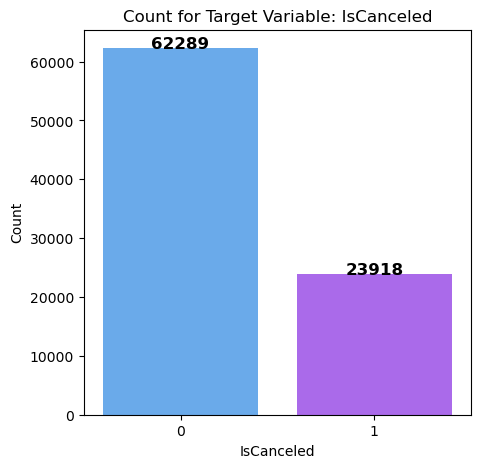

In [11]:
plt.figure(figsize=(5,5))

ax = sns.countplot(x='IsCanceled', data=df, palette='cool')

ax.set_ylabel('Count')
ax.set_xlabel('IsCanceled')
ax.set_title('Count for Target Variable: IsCanceled')
for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        ax.text(x+width-0.4, 
                y+height,
                '{:.0f}'.format(height),
                weight='bold',
                horizontalalignment='center',
                size='large') 
        
plt.show()

### Observations:
There is a large class imbalance in our target variable, this is something we need to keep in mind for later in modeling stages of the project.

# PART I: Target vs Features

##  1) `Hotel`

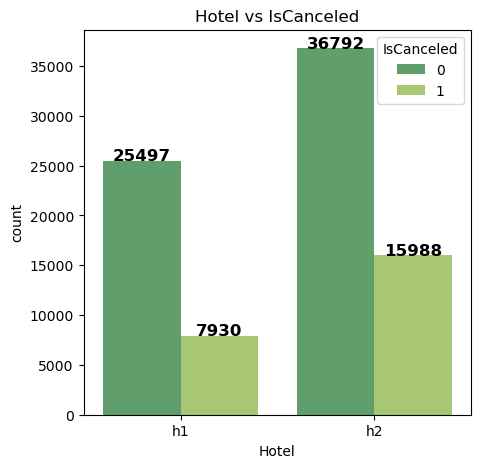

In [12]:
plt.figure(figsize=(5,5))


ax = sns.countplot(hue='IsCanceled', data=df, x='Hotel',palette='summer')

for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        ax.text(x+width-0.2, 
                y+height,
                '{:.0f}'.format(height),
                weight='bold',
                horizontalalignment='center',
                size='large') 
plt.title('Hotel vs IsCanceled')        
plt.show()

In [13]:
# Let's look at a crosstabulation normalized by the hotel
pd.crosstab(index=df['Hotel'], columns=df['IsCanceled'], normalize='index')

IsCanceled,0,1
Hotel,,
h1,0.762767,0.237233
h2,0.697082,0.302918


### Observations:

* 23% of bookings in Hotel 1 (resort) are cancelled
* 30% of bookings in Hotel 2 (city) are cancelled

## 2) `Continent`

In [14]:
# It may be a good idea to recode the countries as their cooresponding Region or Continent
# This will give us less groups (and less dummy variables when we get to that step)
country_tables = pd.read_html('https://statisticstimes.com/geography/countries-by-continents.php')
countries = country_tables[2][['Country or Area', 'ISO-alpha3 Code', 'Region 1', 'Continent']]
countries.head()

,Country or Area,ISO-alpha3 Code,Region 1,Continent
0,Afghanistan,AFG,Southern Asia,Asia
1,Åland Islands,ALA,Northern Europe,Europe
2,Albania,ALB,Southern Europe,Europe
3,Algeria,DZA,Northern Africa,Africa
4,American Samoa,ASM,Polynesia,Oceania


In [15]:
country_continent = df['Country'].to_frame().merge(countries[['ISO-alpha3 Code','Continent']], how='left', left_on='Country', right_on='ISO-alpha3 Code')
country_continent.head()

,Country,ISO-alpha3 Code,Continent
0,GBR,GBR,Europe
1,GBR,GBR,Europe
2,GBR,GBR,Europe
3,PRT,PRT,Europe
4,PRT,PRT,Europe


In [16]:
df['Continent'] = country_continent['Continent']
df.head()

,Hotel,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,res_equals_assign,Continent
0,h1,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NULL,NULL,0,Transient,75.0,0,0,Check-Out,2015-07-02,0,Europe
1,h1,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304,NULL,0,Transient,75.0,0,0,Check-Out,2015-07-02,1,Europe
2,h1,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240,NULL,0,Transient,98.0,0,1,Check-Out,2015-07-03,1,Europe
3,h1,0,0,2015,July,27,1,0,2,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,0,No Deposit,NULL,NULL,0,Transient,107.0,0,0,Check-Out,2015-07-03,1,Europe
4,h1,0,9,2015,July,27,1,0,2,2,0.0,0,FB,PRT,Direct,Direct,0,0,0,C,C,0,No Deposit,303,NULL,0,Transient,103.0,0,1,Check-Out,2015-07-03,1,Europe


In [17]:
df['Continent'] = df['Continent'].fillna('unknown')
df['Continent'].value_counts()

Europe           76204
Asia              2509
South America     2436
North America     2019
unknown           1573
Africa            1016
Oceania            448
Antarctica           2
Name: Continent, dtype: int64

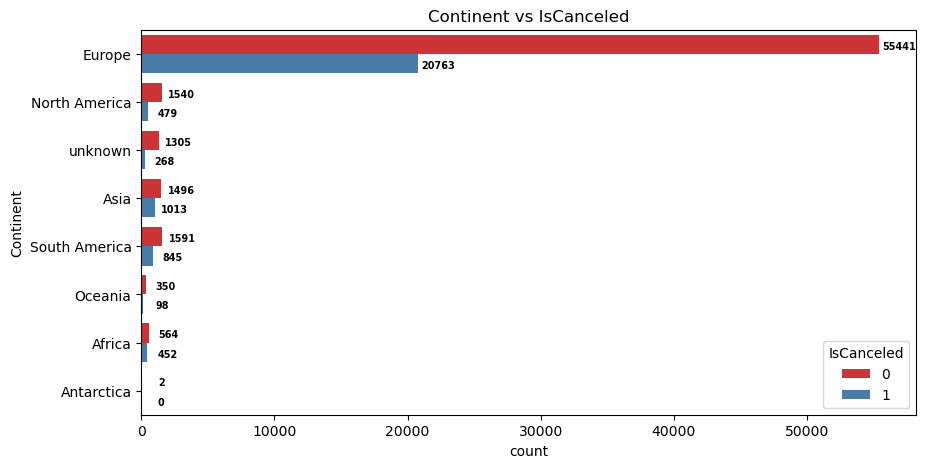

In [18]:
plt.figure(figsize=(10,5))


ax = sns.countplot(hue='IsCanceled', data=df, y='Continent',palette='Set1')

for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        ax.text(x+width+1500, 
                y+height-0.1,
                '{:.0f}'.format(width),
                weight='bold',
                horizontalalignment='center',
                size='x-small') 
        
plt.title('Continent vs IsCanceled')                
plt.show()

In [19]:
pd.crosstab(index=df['Continent'], columns=df['IsCanceled'], normalize='index')

IsCanceled,0,1
Continent,,
Africa,0.555118,0.444882
Antarctica,1.000000,0.000000
Asia,0.596253,0.403747
Europe,0.727534,0.272466
North America,0.762754,0.237246
Oceania,0.781250,0.218750
South America,0.653120,0.346880
unknown,0.829625,0.170375


In [80]:
df['is_europe'] = np.where(df['Continent'] == 'Europe', 1, 0)
df['is_europe'].value_counts()

1    76204
0    10003
Name: is_europe, dtype: int64

In [81]:
pd.crosstab(index=df['is_europe'], columns=df['IsCanceled'], normalize='index')

IsCanceled,0,1
is_europe,,
0,0.684595,0.315405
1,0.727534,0.272466


### Observations:
* Customers from Africa and Asia have the highest percentage of cancellations with 44% and 40% respectively
* 17% of cancellations have an unknown continent
* More cancellations happen for people coming from outside of Europe

## 3) `LeadTime`

In [20]:
lead_time_stats = df.groupby('IsCanceled')['LeadTime'].agg(['mean', 'median'])
lead_time_stats

,mean,median
IsCanceled,,
0,70.438665,38.0
1,105.704741,80.0


In [21]:
median_0 = lead_time_stats['median'][0]
median_1 = lead_time_stats['median'][1]

findfont: Font family ['roboto'] not found. Falling back to DejaVu Sans.


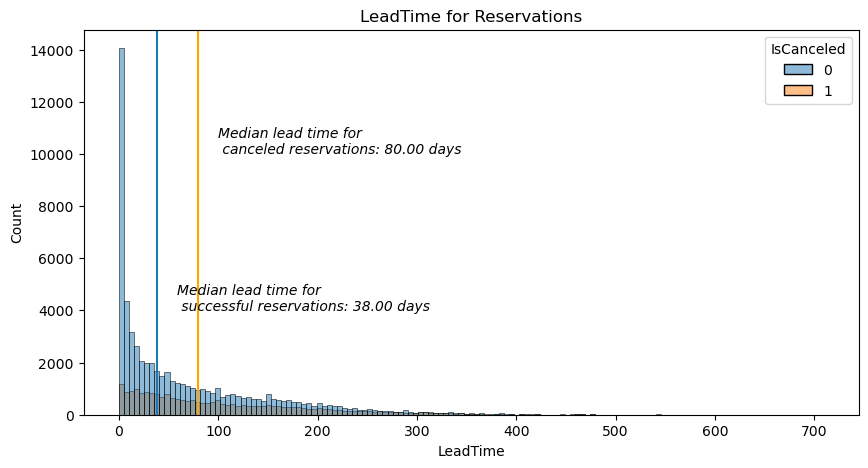

In [22]:
plt.figure(figsize=(10,5))


ax = sns.histplot(data=df,x='LeadTime', hue='IsCanceled')

ax.axvline(x=median_1, color='orange')
ax.axvline(x=median_0)

ax.annotate(f'Median lead time for \n canceled reservations: {median_1:.2f} days', 
             xy=(median_1+20, 10000),
            font='roboto',
            fontstyle='italic')
ax.annotate(f'Median lead time for \n successful reservations: {median_0:.2f} days', 
             xy=(median_0+20, 4000),
            font='roboto',
            fontstyle='italic')
plt.title('LeadTime for Reservations')
plt.show()

In [23]:
from scipy import stats
# The point biserial correlation is used to measure the relationship between a binary and continuous variable

stats.pointbiserialr(df['LeadTime'], df['IsCanceled'])

PointbiserialrResult(correlation=0.18393237741859186, pvalue=0.0)

### Observations:
* There is a slight correlation between `LeadTime` and `IsCanceled` of 0.18
* The median (and mean) value for `LeadTime` is larger for canceled bookings. This intuitively makes sense, we should expect that making a reservation 80 days in advance will be more likely to cancel as opposed to making a booking 38 days in advance.

# 4) Arrival Date Features

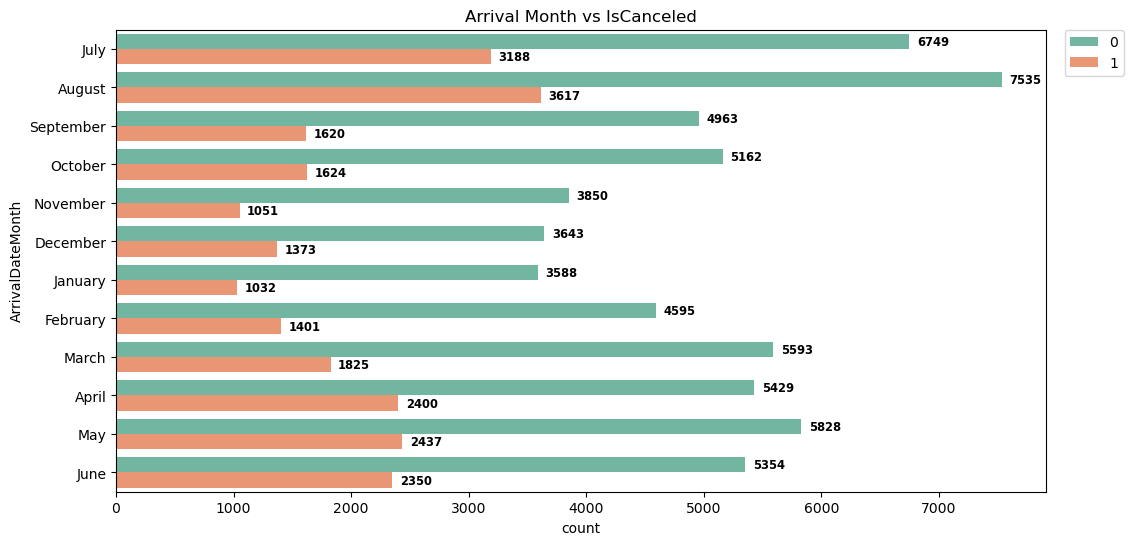

In [24]:
plt.figure(figsize=(12,6))


ax = sns.countplot(hue='IsCanceled', data=df, y='ArrivalDateMonth',palette='Set2')


for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        ax.text(x+width+200, 
                y+height-0.1,
                '{:.0f}'.format(width),
                weight='bold',
                horizontalalignment='center',
                size='small') 
plt.title('Arrival Month vs IsCanceled')        
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)        
plt.show()

In [25]:
pd.crosstab(index=df['ArrivalDateMonth'], columns=df['IsCanceled'], normalize='index').sort_values(by=1)

IsCanceled,0,1
ArrivalDateMonth,,
November,0.785554,0.214446
January,0.776623,0.223377
February,0.766344,0.233656
October,0.760684,0.239316
March,0.753977,0.246023
September,0.753912,0.246088
December,0.726276,0.273724
May,0.705142,0.294858
June,0.694964,0.305036


In [26]:
# We will recode the months to their cooresponding integers
month_mapping = {'January':1,
                 'February':2,
                 'March':3,
                 'April':4,
                 'May':5,
                 'June':6,
                 'July':7,
                 'August':8,
                 'September':9,
                 'October':10,
                 'November':11,
                 'December':12}


df['ArrivalDateMonth'] = df['ArrivalDateMonth'].map(month_mapping)

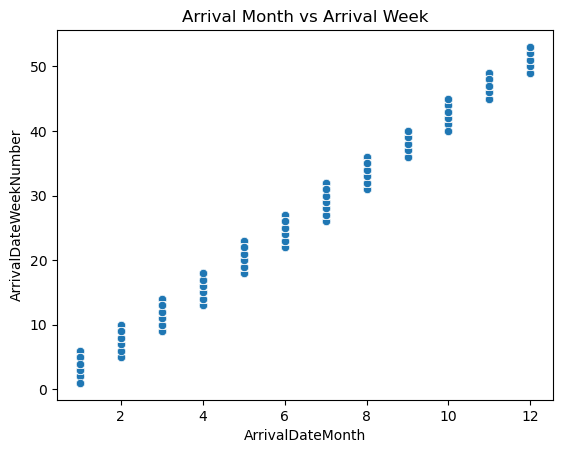

In [27]:
# There is an expected correlation between ArrivalDateMonth and ArrivalDateWeekNumber, let's look at a scatterplot

sns.scatterplot(data=df, x='ArrivalDateMonth', y='ArrivalDateWeekNumber')
plt.title('Arrival Month vs Arrival Week')
plt.show()

In [28]:
df[['ArrivalDateMonth','ArrivalDateWeekNumber']].corr()

,ArrivalDateMonth,ArrivalDateWeekNumber
ArrivalDateMonth,1.000000,0.995062
ArrivalDateWeekNumber,0.995062,1.000000


### Observations:
* We will not be including `ArrivalDateYear` as one of our features. The goal of this project is to predict cancellations for upcoming years, so this will not be a useful feature.

* Summer month (June, July, August) bookings have the highest percentage of cancellations (between 30-32%)

* There is a linear relationship between `ArrivalDateMonth` and `ArrivalDateWeekNumber`, which is to be expected. We will only be keeping `ArrivalDateMonth` to avoid redundancy.

* It is unclear if `ArrivalDateMonth` and `ArrivalDateDayOfMonth` will be useful features, but we will keep them both for now.


# 5) `Adults`, `Children`, and `Babies`

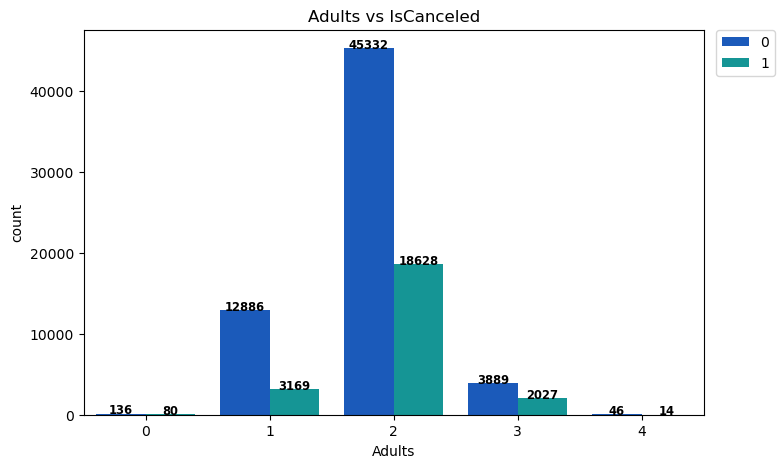

In [200]:
plt.figure(figsize=(8,5))

ax = sns.countplot(data=df, hue='IsCanceled', x='Adults', palette='winter')



for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        ax.text(x+width-0.2, 
                y+height,
                '{:.0f}'.format(height),
                weight='bold',
                horizontalalignment='center',
                size='small') 
plt.title('Adults vs IsCanceled')        
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)        
plt.show()

In [25]:
pd.crosstab(index=df['Adults'], columns=df['IsCanceled'], normalize='index')

IsCanceled,0,1
Adults,,
0,0.629630,0.370370
1,0.802616,0.197384
2,0.708755,0.291245
3,0.657370,0.342630
4,0.766667,0.233333


In [29]:

df['total_people'] = df['Children'] + df['Babies'] + df['Adults']
df['total_people'].value_counts(normalize=True)

2.0     0.656211
1.0     0.181273
3.0     0.116290
4.0     0.044648
5.0     0.001543
12.0    0.000023
10.0    0.000012
Name: total_people, dtype: float64

In [30]:
pd.crosstab(index=df['total_people'], columns=df['IsCanceled'], normalize='index')

IsCanceled,0,1
total_people,,
1.0,0.804569,0.195431
2.0,0.715945,0.284055
3.0,0.685087,0.314913
4.0,0.582749,0.417251
5.0,0.766917,0.233083
10.0,1.000000,0.000000
12.0,0.500000,0.500000


## Observations:
* Bookings with 3 people cancel 32% of the time
* Bookings with 4 people cancel 42% of the time

# 6) `StaysInWeekendNights` and `StaysInWeekNights`

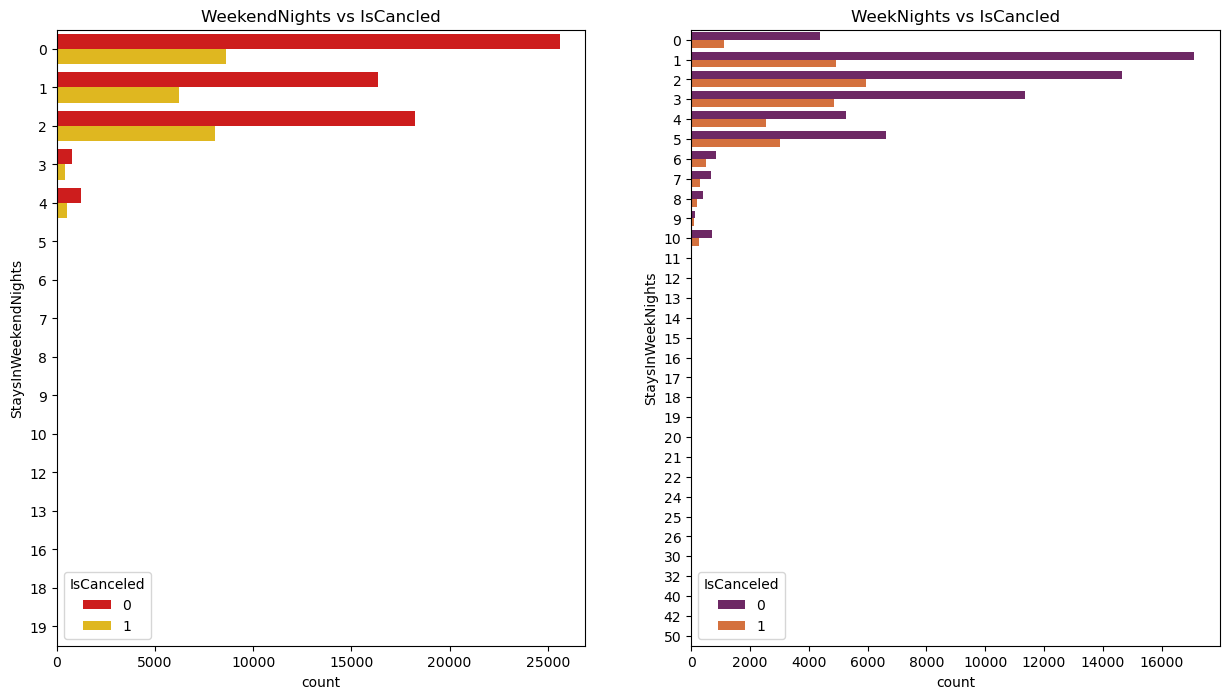

In [31]:
plt.figure(figsize=(15,8))

plt.subplot(1,2,1)
ax = sns.countplot(data=df, hue='IsCanceled', y='StaysInWeekendNights', palette='hot')
plt.title('WeekendNights vs IsCancled')

plt.subplot(1,2,2)
ax2 = sns.countplot(data=df, hue='IsCanceled', y='StaysInWeekNights', palette='inferno')  
plt.title('WeekNights vs IsCancled')

plt.show()

In [32]:
pd.crosstab(index=df['StaysInWeekendNights'], columns=df['IsCanceled'], normalize='index').head(7)

IsCanceled,0,1
StaysInWeekendNights,,
0,0.748402,0.251598
1,0.725106,0.274894
2,0.693715,0.306285
3,0.659312,0.340688
4,0.697445,0.302555
5,0.462687,0.537313
6,0.500000,0.500000


In [33]:
pd.crosstab(index=df['StaysInWeekNights'], columns=df['IsCanceled'], normalize='index').head(12)

IsCanceled,0,1
StaysInWeekNights,,
0,0.797378,0.202622
1,0.776653,0.223347
2,0.711463,0.288537
3,0.700926,0.299074
4,0.674202,0.325798
5,0.687039,0.312961
6,0.619883,0.380117
7,0.691667,0.308333
8,0.673235,0.326765


In [34]:
df['total_nights'] = df['StaysInWeekNights'] + df['StaysInWeekendNights']
df['is_weekend'] = np.where(df['StaysInWeekendNights'] > 0, 1, 0)

In [37]:
pd.crosstab(index=df['total_nights'], columns=df['IsCanceled'], normalize='index').head(12)

IsCanceled,0,1
total_nights,,
1,0.815598,0.184402
2,0.731740,0.268260
3,0.699397,0.300603
4,0.694829,0.305171
5,0.695342,0.304658
6,0.653645,0.346355
7,0.693570,0.306430
8,0.622159,0.377841
9,0.645537,0.354463


In [36]:
pd.crosstab(index=df['is_weekend'], columns=df['IsCanceled'], normalize='index').head(12)

IsCanceled,0,1
is_weekend,,
0,0.748402,0.251598
1,0.705509,0.294491


### Observations:

# 7) `Meal`

`Meal` : Type of meal package
   * Undefined/SC – no meal package;
   * BB – Bed & Breakfast;
   * HB – Half board (breakfast and one other meal – usually dinner);
   * FB – Full board (breakfast, lunch and dinner)

In [38]:
# Because Undefined/SC both coorespond to no meal package, let's combine these
# There is also some weird whitespace in the column, so we will remove that with 

df['Meal'] = df['Meal'].replace('Undefined','SC       ').str.strip()

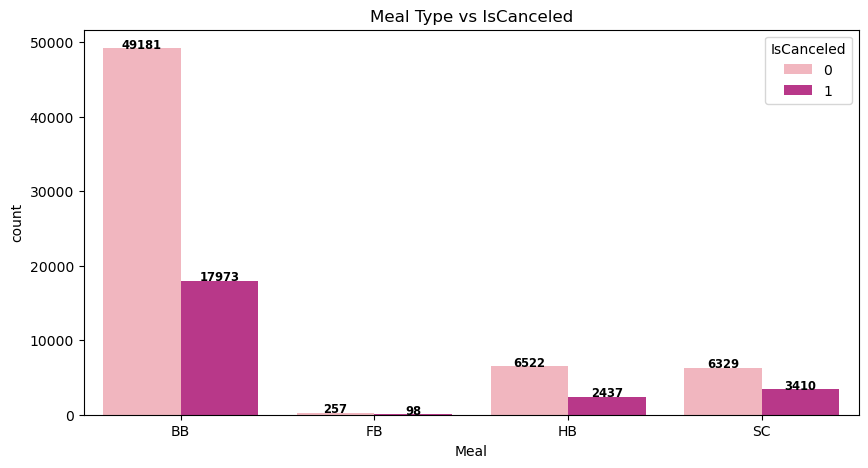

In [39]:
plt.figure(figsize=(10,5))
ax = sns.countplot(data=df, hue='IsCanceled', x='Meal', palette='RdPu')

for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        ax.text(x+width-0.2, 
                y+height,
                '{:.0f}'.format(height),
                weight='bold',
                horizontalalignment='center',
                size='small')
        
plt.title('Meal Type vs IsCanceled')        
plt.show()

In [40]:
pd.crosstab(index=df['Meal'], columns=df['IsCanceled'], normalize='index')

IsCanceled,0,1
Meal,,
BB,0.732361,0.267639
FB,0.723944,0.276056
HB,0.727983,0.272017
SC,0.649861,0.350139


In [41]:
# Binarize Meal to  has_meal = 1 and no_meal = 0
df['Meal'] = np.where(df['Meal'] == 'SC', 0, 1)

pd.crosstab(index=df['Meal'], columns=df['IsCanceled'], normalize='index')

IsCanceled,0,1
Meal,,
0,0.649861,0.350139
1,0.731809,0.268191


### Observations:
* The highest percentage of cancellations come from bookings with no meal plan (SC) at 34%

# 8) `MarketSegment` and `CustomerType`

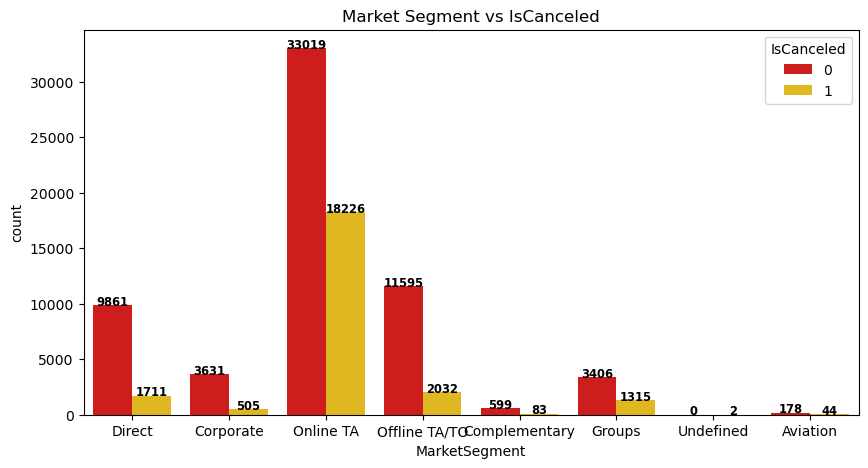

In [42]:
plt.figure(figsize=(10,5))
ax = sns.countplot(data=df, hue='IsCanceled', x='MarketSegment', palette='hot')

for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        ax.text(x+width-0.2, 
                y+height,
                '{:.0f}'.format(height),
                weight='bold',
                horizontalalignment='center',
                size='small')
        
plt.title('Market Segment vs IsCanceled')        
plt.show()

In [43]:
pd.crosstab(index=df['MarketSegment'], columns=df['IsCanceled'], normalize='index')

IsCanceled,0,1
MarketSegment,,
Aviation,0.801802,0.198198
Complementary,0.878299,0.121701
Corporate,0.877901,0.122099
Direct,0.852143,0.147857
Groups,0.721457,0.278543
Offline TA/TO,0.850884,0.149116
Online TA,0.644336,0.355664
Undefined,0.000000,1.000000


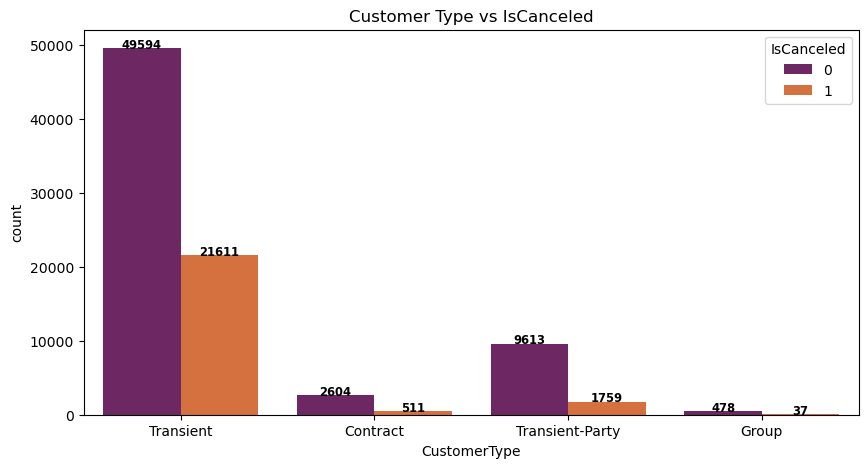

In [44]:
plt.figure(figsize=(10,5))
ax = sns.countplot(data=df, hue='IsCanceled', x='CustomerType', palette='inferno')

for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        ax.text(x+width-0.2, 
                y+height,
                '{:.0f}'.format(height),
                weight='bold',
                horizontalalignment='center',
                size='small')
        
plt.title('Customer Type vs IsCanceled')        
plt.show()

In [45]:
pd.crosstab(index=df['CustomerType'], columns=df['IsCanceled'], normalize='index')

IsCanceled,0,1
CustomerType,,
Contract,0.835955,0.164045
Group,0.928155,0.071845
Transient,0.696496,0.303504
Transient-Party,0.845322,0.154678


### Observations:
* Market Segement that cancels the most is Online TA (42%)
* Customer Type that cancels the most is Transient (37%)

# 9) `IsRepeatedGuest`, `PreviousCancellations`, and `PreviousBookingsNotCanceled`

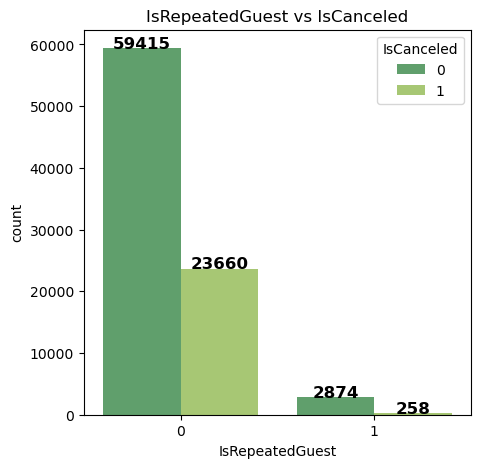

In [46]:
plt.figure(figsize=(5,5))


ax = sns.countplot(hue='IsCanceled', data=df, x='IsRepeatedGuest',palette='summer')

for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        ax.text(x+width-0.2, 
                y+height,
                '{:.0f}'.format(height),
                weight='bold',
                horizontalalignment='center',
                size='large') 
plt.title('IsRepeatedGuest vs IsCanceled')        
plt.show()

In [47]:
pd.crosstab(index=df['IsRepeatedGuest'], columns=df['IsCanceled'], normalize='index')

IsCanceled,0,1
IsRepeatedGuest,,
0,0.715197,0.284803
1,0.917625,0.082375


### Observations:
* Only 8% of repeat guests cancel their bookings
* 28% of new guests cancel their bookings

In [48]:
df['cancellation_rate'] = (df['PreviousCancellations']/(df['PreviousCancellations']+df['PreviousBookingsNotCanceled'])).fillna(0)

In [49]:
stats.pointbiserialr(df['cancellation_rate'], df['IsCanceled'])

PointbiserialrResult(correlation=0.16914832503856803, pvalue=0.0)

# 10) `ReservedRoomType`, `AssignedRoomType`, and `res_equals_assign`

In [50]:
# Create new features
condition = df['ReservedRoomType'] == df['AssignedRoomType']
df['res_equals_assign'] = np.where(condition, 1, 0)

df[['ReservedRoomType','AssignedRoomType','res_equals_assign']].head()

,ReservedRoomType,AssignedRoomType,res_equals_assign
0,A,C,0
1,A,A,1
2,A,A,1
3,C,C,1
4,C,C,1


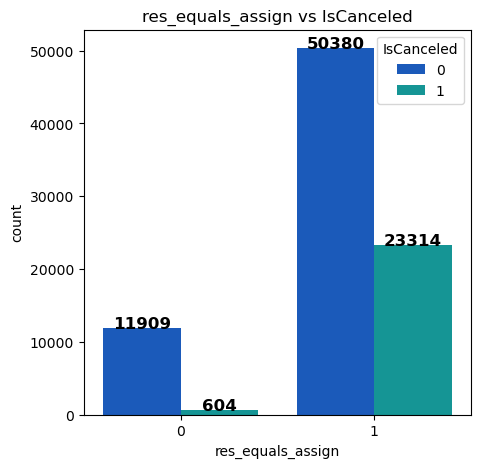

In [52]:
plt.figure(figsize=(5,5))


ax = sns.countplot(hue='IsCanceled', data=df, x='res_equals_assign',palette='winter')

for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        ax.text(x+width-0.2, 
                y+height,
                '{:.0f}'.format(height),
                weight='bold',
                horizontalalignment='center',
                size='large') 
plt.title('res_equals_assign vs IsCanceled') 
plt.show()

In [53]:
pd.crosstab(index=df['res_equals_assign'], columns=df['IsCanceled'], normalize='index')

IsCanceled,0,1
res_equals_assign,,
0,0.951730,0.048270
1,0.683638,0.316362


### Observations:
* Interestingly, the group that does not recieve the room type that was reserved only cancel 4.8%. This could be due to customers recieving room upgrades making them less likely to cancel
* The group that DOES recieve the same room type that was reserved cancels 31.6% of the time

# 11)  `BookingChanges`

In [54]:
df['BookingChanges'].value_counts(normalize=True)

0     0.820212
1     0.123586
2     0.039765
3     0.009860
4     0.003921
5     0.001230
6     0.000626
7     0.000325
8     0.000139
9     0.000081
10    0.000070
13    0.000046
14    0.000035
15    0.000035
16    0.000023
12    0.000012
17    0.000012
18    0.000012
11    0.000012
Name: BookingChanges, dtype: float64

In [55]:
# Binarize BookingChanges
df['BookingChanges'] = np.where(df['BookingChanges'] > 0, 1, 0)
df['BookingChanges'].value_counts()

0    70708
1    15499
Name: BookingChanges, dtype: int64

In [56]:
pd.crosstab(index=df['BookingChanges'], columns=df['IsCanceled'], normalize='index').head(10)

IsCanceled,0,1
BookingChanges,,
0,0.696272,0.303728
1,0.842441,0.157559


### Observations:
* Bookings that make changes cancel 16% of the time
* Bookings that DON'T make changes cancel 30% of the time

# 12) `DepositType`

In [57]:
df['DepositType'].value_counts()

No Deposit         85062
Non Refund          1038
Refundable           107
Name: DepositType, dtype: int64

In [58]:
pd.crosstab(index=df['DepositType'], columns=df['IsCanceled'], normalize='index')

IsCanceled,0,1
DepositType,,
No Deposit,0.730679,0.269321
Non Refund,0.052987,0.947013
Refundable,0.757009,0.242991


In [59]:
df['DepositType'] = df['DepositType'].str.strip()
df['DepositType'].unique()

array(['No Deposit', 'Refundable', 'Non Refund'], dtype=object)

In [60]:
df.query('DepositType == "Non Refund"')['MarketSegment'].value_counts(normalize=True)

Groups           0.634875
Offline TA/TO    0.276493
Corporate        0.061657
Online TA        0.017341
Direct           0.009634
Name: MarketSegment, dtype: float64

### Observations:

* Non Refundable bookings cancel 94% of the time. 64% of these are group bookings, so that intuitevly makes sense

# 13) `Agent`

In [61]:
# Strip off the white space
df['Agent'] = df['Agent'].str.strip()

In [62]:
# Create a dataframe of just the agent column
df_agent = df['Agent'].to_frame()

# Create a dataframe of the count for each agent
df_agent_count = df.groupby('Agent')['Agent'].count().to_frame(name='counts')
df_agent_count = df_agent_count.reset_index()

# Merge the two dataframes so we can have the count for each agent
df_agent_and_count = pd.merge(df_agent, df_agent_count, on = 'Agent', how='left')
df_agent_and_count.head()

,Agent,counts
0,NULL,11836
1,304,1
2,240,12900
3,NULL,11836
4,303,2


In [63]:
# Create list of conditions for recoding

conditions = [df_agent_and_count['Agent'] == "NULL",
              df_agent_and_count['counts'] <= 100,
              (df_agent_and_count['counts'] > 100)  & (df_agent_and_count['counts'] < 1000),
              df_agent_and_count['counts'] >= 1000]

# Create list of categories for recoding

options = ['no_agent', 'uncommon_agent','common_agent','popular_agent']


# Create new column based on the conditions and category options
df_agent_and_count['agent_type'] = np.select(conditions, options)
df_agent_and_count.head()

,Agent,counts,agent_type
0,NULL,11836,no_agent
1,304,1,uncommon_agent
2,240,12900,popular_agent
3,NULL,11836,no_agent
4,303,2,uncommon_agent


In [64]:
# Create new column in original df that is equivalent to this new recoded agent_type column
df['agent_type'] = df_agent_and_count['agent_type']
df['agent_type'].value_counts()

popular_agent     57610
common_agent      12297
no_agent          11836
uncommon_agent     4464
Name: agent_type, dtype: int64

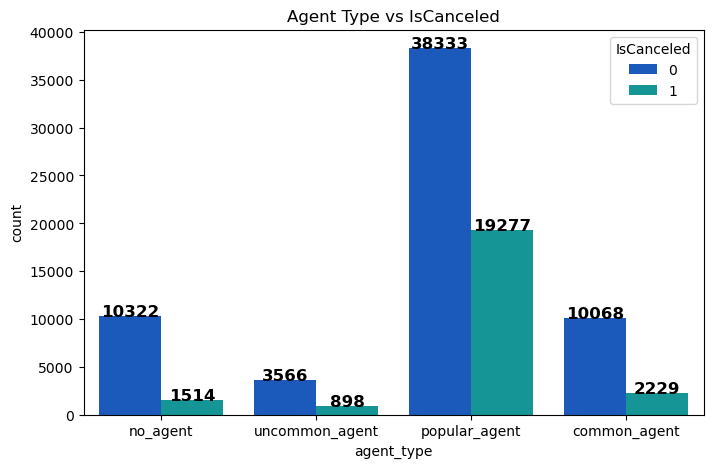

In [65]:
plt.figure(figsize=(8,5))


ax = sns.countplot(hue='IsCanceled', data=df, x='agent_type',palette='winter')
for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        ax.text(x+width-0.2, 
                y+height,
                '{:.0f}'.format(height),
                weight='bold',
                horizontalalignment='center',
                size='large') 
plt.title('Agent Type vs IsCanceled')       
plt.show()

In [66]:
pd.crosstab(index=df['agent_type'], columns=df['IsCanceled'], normalize='index')

IsCanceled,0,1
agent_type,,
common_agent,0.818736,0.181264
no_agent,0.872085,0.127915
popular_agent,0.665388,0.334612
uncommon_agent,0.798835,0.201165


## Observations:
* Based on the way we recoded the agent column, bookings with a popular agent cancel 33% of the time
* Under the assumption that the 'NULL' bookings were mostly comprised of bookings with no agent involved, they only cancel 12.7% of the time

# 14) `DaysInWaitingList`

In [67]:
df['DaysInWaitingList'].value_counts(normalize=True)

0      0.990326
63     0.000615
87     0.000290
44     0.000267
15     0.000255
         ...   
116    0.000012
142    0.000012
52     0.000012
121    0.000012
36     0.000012
Name: DaysInWaitingList, Length: 127, dtype: float64

In [68]:
df['wait_list'] = np.where(df['DaysInWaitingList'] > 0 ,1, 0)
df['wait_list'].value_counts()

0    85373
1      834
Name: wait_list, dtype: int64

In [69]:
pd.crosstab(index=df['wait_list'], columns=df['IsCanceled'], normalize='index')

IsCanceled,0,1
wait_list,,
0,0.723261,0.276739
1,0.649880,0.350120


## Observations:
* Bookings on a wait list cancel 35% of the time

# 15) `ADR`

In [70]:
adr_stats = df.groupby('IsCanceled')['ADR'].agg(['mean', 'median'])
adr_stats

,mean,median
IsCanceled,,
0,103.744606,95.0
1,118.076740,109.8


In [71]:
adr_0 = adr_stats['median'][0] 
adr_1 = adr_stats['median'][1] 

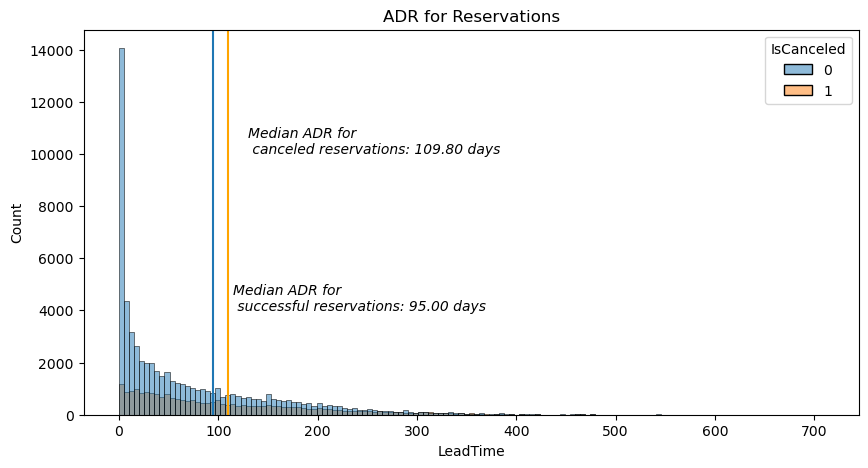

In [72]:
plt.figure(figsize=(10,5))


ax = sns.histplot(data=df,x='LeadTime', hue='IsCanceled')
ax.axvline(x=adr_1, color='orange')
ax.axvline(x=adr_0)

ax.annotate(f'Median ADR for \n canceled reservations: {adr_1:.2f} days', 
             xy=(adr_1+20, 10000),
            font='roboto',
            fontstyle='italic')
ax.annotate(f'Median ADR for \n successful reservations: {adr_0:.2f} days', 
             xy=(adr_0+20, 4000),
            font='roboto',
            fontstyle='italic')

plt.title('ADR for Reservations')
plt.show()

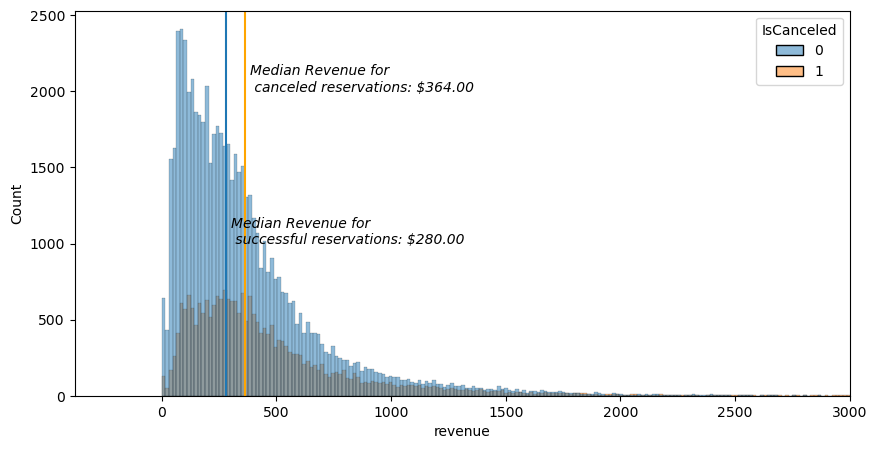

In [89]:
df['revenue'] = df['ADR']*df['total_nights']

rev_stats = df.groupby('IsCanceled')['revenue'].agg(['mean', 'median'])
rev_0 = rev_stats['median'][0] 
rev_1 = rev_stats['median'][1] 

plt.figure(figsize=(10,5))
ax = sns.histplot(data=df,x='revenue', hue='IsCanceled')
ax.axvline(x=rev_1, color='orange')
ax.axvline(x=rev_0)

ax.annotate(f'Median Revenue for \n canceled reservations: ${rev_1:.2f}', 
             xy=(rev_1+20, 2000),
            font='roboto',
            fontstyle='italic')
ax.annotate(f'Median Revenue for \n successful reservations: ${rev_0:.2f}', 
             xy=(rev_0+20, 1000),
            font='roboto',
            fontstyle='italic')

plt.xlim(right=3000)
plt.show()

## Observations:

# 16) `RequiredCarParkingSpaces` and `TotalOfSpecialRequests`

In [73]:
df['RequiredCarParkingSpaces'].value_counts()

0    78937
1     7237
2       28
3        3
8        2
Name: RequiredCarParkingSpaces, dtype: int64

In [74]:
# Binarize RequiredCarParkingSpaces
df['RequiredCarParkingSpaces'] = np.where(df['RequiredCarParkingSpaces'] > 0, 1, 0)

In [75]:
pd.crosstab(index=df['RequiredCarParkingSpaces'], columns=df['IsCanceled'], normalize='index')

IsCanceled,0,1
RequiredCarParkingSpaces,,
0,0.696999,0.303001
1,1.000000,0.000000


In [76]:
df['TotalOfSpecialRequests'].value_counts()

0    43090
1    28742
2    11718
3     2302
4      319
5       36
Name: TotalOfSpecialRequests, dtype: int64

In [103]:
# Binarize TotalOfSpecialRequests
df['special_requests'] = np.where(df['TotalOfSpecialRequests'] > 0, 1, 0)
df['special_requests'].value_counts()

1    43117
0    43090
Name: special_requests, dtype: int64

In [78]:
pd.crosstab(index=df['TotalOfSpecialRequests'], columns=df['IsCanceled'], normalize='index')

IsCanceled,0,1
TotalOfSpecialRequests,,
0,0.663797,0.336203
1,0.781270,0.218730


## Observations:
* Bookings that require parking spaces have no cancellations
* Bookings with special requests cancel less frequently

# PART II: Further Exploration of Relationships

In [104]:
df.columns

Index(['Hotel', 'IsCanceled', 'LeadTime', 'ArrivalDateYear',
       'ArrivalDateMonth', 'ArrivalDateWeekNumber', 'ArrivalDateDayOfMonth',
       'StaysInWeekendNights', 'StaysInWeekNights', 'Adults', 'Children',
       'Babies', 'Meal', 'Country', 'MarketSegment', 'DistributionChannel',
       'IsRepeatedGuest', 'PreviousCancellations',
       'PreviousBookingsNotCanceled', 'ReservedRoomType', 'AssignedRoomType',
       'BookingChanges', 'DepositType', 'Agent', 'Company',
       'DaysInWaitingList', 'CustomerType', 'ADR', 'RequiredCarParkingSpaces',
       'TotalOfSpecialRequests', 'ReservationStatus', 'ReservationStatusDate',
       'res_equals_assign', 'Continent', 'total_people', 'total_nights',
       'is_weekend', 'cancellation_rate', 'agent_type', 'wait_list',
       'is_europe', 'revenue', 'special_requests'],
      dtype='object')

In [105]:
df_clean = df.drop(['ArrivalDateYear','ArrivalDateWeekNumber','Adults',
                    'Children','Babies','Agent','DistributionChannel','ReservedRoomType','AssignedRoomType',
                    'ReservationStatus','Country','Company','DaysInWaitingList','ReservationStatusDate',
                    'StaysInWeekendNights', 'StaysInWeekNights','TotalOfSpecialRequests'], axis=1)

df_clean.columns

Index(['Hotel', 'IsCanceled', 'LeadTime', 'ArrivalDateMonth',
       'ArrivalDateDayOfMonth', 'Meal', 'MarketSegment', 'IsRepeatedGuest',
       'PreviousCancellations', 'PreviousBookingsNotCanceled',
       'BookingChanges', 'DepositType', 'CustomerType', 'ADR',
       'RequiredCarParkingSpaces', 'res_equals_assign', 'Continent',
       'total_people', 'total_nights', 'is_weekend', 'cancellation_rate',
       'agent_type', 'wait_list', 'is_europe', 'revenue', 'special_requests'],
      dtype='object')

In [106]:
col_order = ['IsCanceled','Hotel','Continent','is_europe','LeadTime', 'ArrivalDateMonth',
       'ArrivalDateDayOfMonth','total_nights','ADR','revenue',
       'total_people', 'Meal', 'MarketSegment', 'IsRepeatedGuest',
       'PreviousCancellations', 'PreviousBookingsNotCanceled','agent_type',
       'res_equals_assign', 'BookingChanges', 'DepositType',
       'wait_list', 'CustomerType', 'RequiredCarParkingSpaces',
       'special_requests' ]

In [107]:
df_clean = df_clean[col_order]
df_clean.head()

,IsCanceled,Hotel,Continent,is_europe,LeadTime,ArrivalDateMonth,ArrivalDateDayOfMonth,total_nights,ADR,revenue,total_people,Meal,MarketSegment,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,agent_type,res_equals_assign,BookingChanges,DepositType,wait_list,CustomerType,RequiredCarParkingSpaces,special_requests
0,0,h1,Europe,1,7,7,1,1,75.0,75.0,1.0,1,Direct,0,0,0,no_agent,0,0,No Deposit,0,Transient,0,0
1,0,h1,Europe,1,13,7,1,1,75.0,75.0,1.0,1,Corporate,0,0,0,uncommon_agent,1,0,No Deposit,0,Transient,0,0
2,0,h1,Europe,1,14,7,1,2,98.0,196.0,2.0,1,Online TA,0,0,0,popular_agent,1,0,No Deposit,0,Transient,0,1
3,0,h1,Europe,1,0,7,1,2,107.0,214.0,2.0,1,Direct,0,0,0,no_agent,1,0,No Deposit,0,Transient,0,0
4,0,h1,Europe,1,9,7,1,2,103.0,206.0,2.0,1,Direct,0,0,0,uncommon_agent,1,0,No Deposit,0,Transient,0,1


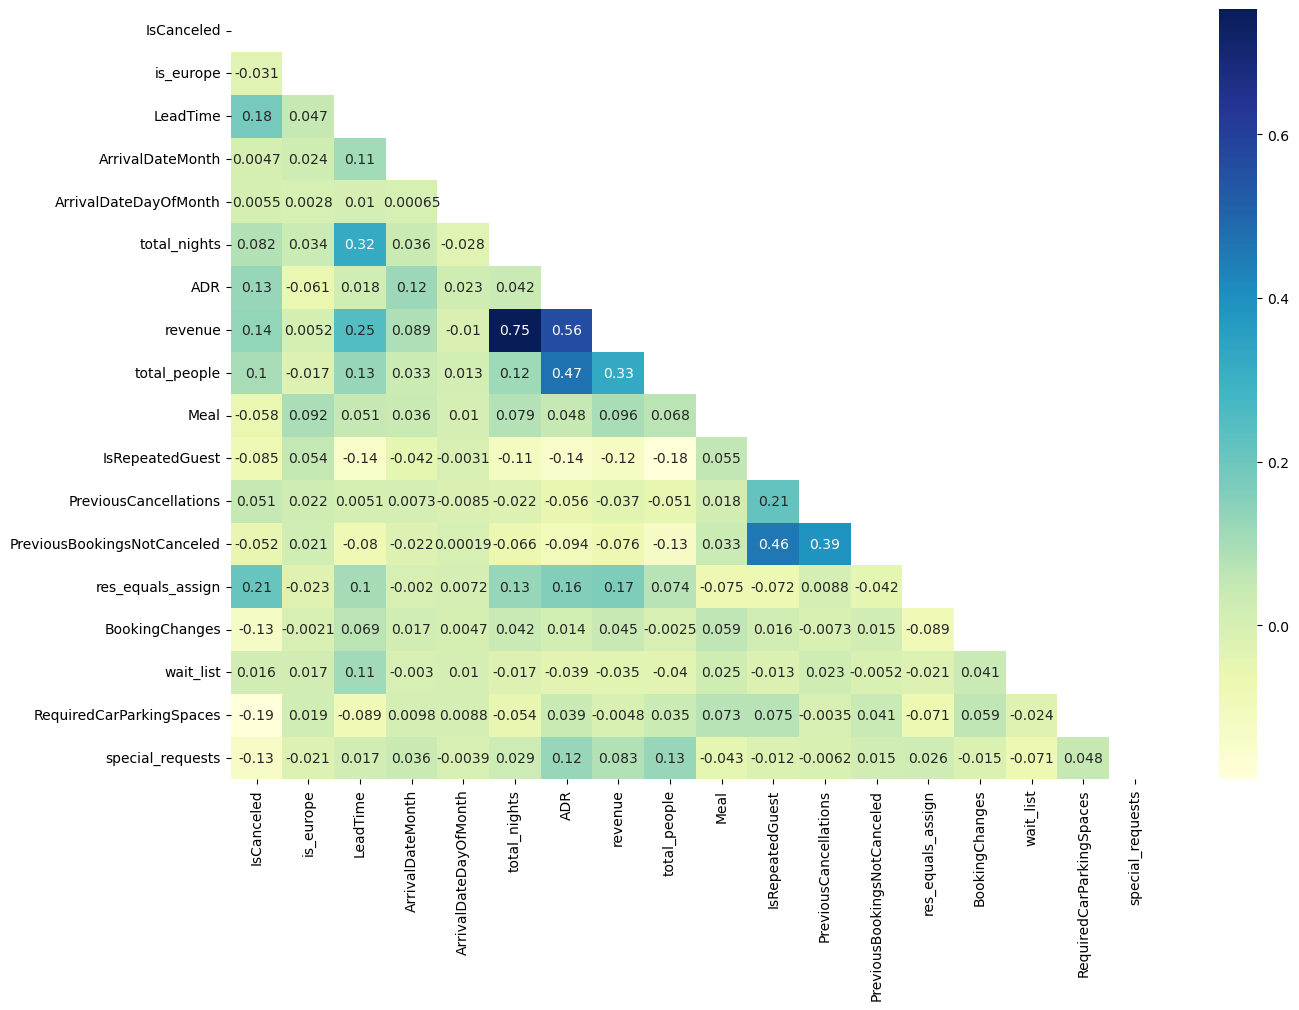

In [108]:
plt.figure(figsize=(15,10))

mask = np.triu(np.ones_like(df_clean.corr()))
sns.heatmap(df_clean.corr(), mask=mask, annot=True, cmap='YlGnBu')

plt.show()

## Observations:
* `IsCanceled` has positive correlations with `LeadTime` (0.18), `ADR`, (0.13), `res_equals_assign` (0.21) and negative correlations with `RequiredCarParkingSpaces` (-0.19) and `TotalOfSpecialRequests` (-0.13)

* `LeadTime` has a fair correlation with `total_nights`(0.32)

* ` IsRepeatedGuest` has a high correlation with `PreviousBookingsNotCancelled` (0.46) and a fair correlation with `PreviousBookingsCanceled` (0.21). Those two features are also correlated with each other (0.39)

* `ADR` has a high correlation with `total_people` (0.44)

* `Revenue` is highly correlated with `total_nights` (0.75), `ADR`(0.56), which is expected because we combined these features

# Testing for Association:

Here we will be using Chi-squared tests, as well as Cramer's V test statistic, to test for an association between each categorical feature against the target feature

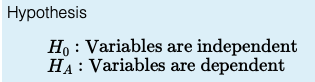

In [109]:
df_clean.columns

Index(['IsCanceled', 'Hotel', 'Continent', 'is_europe', 'LeadTime',
       'ArrivalDateMonth', 'ArrivalDateDayOfMonth', 'total_nights', 'ADR',
       'revenue', 'total_people', 'Meal', 'MarketSegment', 'IsRepeatedGuest',
       'PreviousCancellations', 'PreviousBookingsNotCanceled', 'agent_type',
       'res_equals_assign', 'BookingChanges', 'DepositType', 'wait_list',
       'CustomerType', 'RequiredCarParkingSpaces', 'special_requests'],
      dtype='object')

In [110]:
from scipy.stats.contingency import association
from scipy.stats import chi2_contingency

chi2_columns = ['Hotel', 'Continent','is_europe', 'Meal', 'MarketSegment',
       'IsRepeatedGuest', 'agent_type', 'res_equals_assign',
       'DepositType', 'wait_list', 'CustomerType','RequiredCarParkingSpaces','special_requests']


chi_results=[]
for col in df_clean[chi2_columns].columns:
    cross_tab = pd.crosstab(index=df_clean[col], columns=df_clean['IsCanceled'])
    stat, p, dof, expected = chi2_contingency(cross_tab)
    cramer = association(cross_tab) 

    chi_results.append(
        {
            'column': col,
            'chi_stat': stat,
            'p-value': p,
            'Cramer V': cramer
        }
    )

results = pd.DataFrame(chi_results)

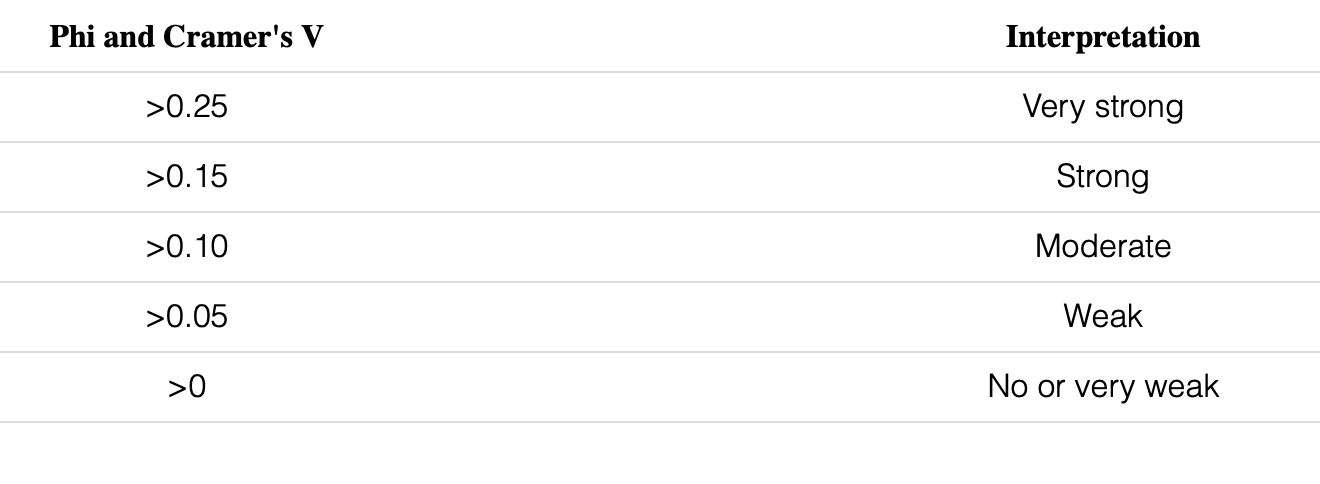

In [111]:
results.sort_values(by='Cramer V', ascending=False)

,column,chi_stat,p-value,Cramer V
4,MarketSegment,4245.359462,0.000000e+00,0.221915
7,res_equals_assign,3833.695496,0.000000e+00,0.210918
11,RequiredCarParkingSpaces,3047.154608,0.000000e+00,0.188054
6,agent_type,2956.290383,0.000000e+00,0.185183
8,DepositType,2349.962878,0.000000e+00,0.165105
12,special_requests,1482.978659,0.000000e+00,0.131184
10,CustomerType,1404.573035,2.998208e-304,0.127644
5,IsRepeatedGuest,615.922305,5.762962e-136,0.084595
1,Continent,524.434705,4.463469e-109,0.077996
0,Hotel,440.123351,1.017654e-97,0.071479


In [112]:
df_clean.corr()['IsCanceled'].to_frame().sort_values(by='IsCanceled', ascending=False)[1:]

,IsCanceled
res_equals_assign,0.210918
LeadTime,0.183932
revenue,0.135016
ADR,0.126152
total_people,0.100367
total_nights,0.081672
PreviousCancellations,0.050797
wait_list,0.016042
ArrivalDateDayOfMonth,0.005476
ArrivalDateMonth,0.004739


## Observations:

* According to the chi-squared test, there is sufficicent evidence to reject the null hypothesis for each feature.

* According to the Cramer's V statistic, and using the interpretation chart above, `MarketSegment`, `res_equals_assign`,`agent_type`, `DepositType`, `CustomerType`, and `TotalOfSpecialRequests` have a moderate to strong association with the target.

* `AssignedRoomType`, `IsRepeatedGuest`, `Continent`, `Hotel`, `Meal`, and `ReservedRoomType` have a weak association.

* `wait_list` has a very weak association.



In [113]:
df_clean.columns

Index(['IsCanceled', 'Hotel', 'Continent', 'is_europe', 'LeadTime',
       'ArrivalDateMonth', 'ArrivalDateDayOfMonth', 'total_nights', 'ADR',
       'revenue', 'total_people', 'Meal', 'MarketSegment', 'IsRepeatedGuest',
       'PreviousCancellations', 'PreviousBookingsNotCanceled', 'agent_type',
       'res_equals_assign', 'BookingChanges', 'DepositType', 'wait_list',
       'CustomerType', 'RequiredCarParkingSpaces', 'special_requests'],
      dtype='object')

In [115]:
df_clean.drop(['PreviousBookingsNotCanceled','ADR','total_nights'],axis=1, inplace=True)

In [116]:
df_clean.to_csv('data/clean_data.csv')